<a href="https://colab.research.google.com/github/santiagopinzon92/evaluacion-final-u2-ml/blob/main/SP_Copia_de_Random_Forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# En profundidad: Árboles de decisión y bosques aleatorios

Anteriormente hemos analizado en profundidad un clasificador generativo simple (Naive Bayes; ver [En profundidad: Clasificación Naive Bayes](05.05-Naive-Bayes.ipynb)) y un clasificador discriminativo poderoso (máquinas de vectores de soporte; ver [En profundidad: Máquinas de vectores de soporte](05.07-Support-Vector-Machines.ipynb)).
Aquí vamos a examinar otro algoritmo poderoso: un algoritmo no paramétrico llamado *random forests* (bosques aleatorios).

Los bosques aleatorios son un ejemplo de un método de *conjunto* (*ensemble*), lo que significa que se basa en agregar los resultados de un conjunto de estimadores más simples.
El resultado algo sorprendente de estos métodos de conjunto es que la suma puede ser mayor que las partes: es decir, la precisión predictiva de un voto mayoritario entre varios estimadores puede terminar siendo mejor que la de cualquiera de los estimadores individuales que participan en la votación.

Veremos ejemplos de esto en las siguientes secciones.

Comenzamos con las importaciones estándar:


In [1]:
!pip install seaborn
import seaborn as sns

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('seaborn-whitegrid')
sns.set_style("whitegrid")

## Motivando los Bosques Aleatorios: Árboles de Decisión

Los bosques aleatorios son un ejemplo de un ensemble learner construido a partir de árboles de decisión.
Por esta razón, comenzaremos discutiendo los propios árboles de decisión.

Los árboles de decisión son formas extremadamente intuitivas de clasificar o etiquetar objetos: simplemente se hace una serie de preguntas diseñadas para llegar a la clasificación correcta.
Por ejemplo, si quisieras construir un árbol de decisión para clasificar los animales que encuentras durante una caminata, podrías construir uno como el que se muestra en la figura siguiente.

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/images/05.08-decision-tree.png?raw=1)
[figure source in Appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Decision-Tree-Example)

La división binaria hace que esto sea extremadamente eficiente: en un árbol bien construido, cada pregunta reducirá aproximadamente a la mitad el número de opciones, acotando rápidamente las posibilidades incluso entre un gran número de clases.
El truco, por supuesto, consiste en decidir qué preguntas hacer en cada paso.
En las implementaciones de árboles de decisión en aprendizaje automático, las preguntas generalmente toman la forma de divisiones alineadas con los ejes de los datos: es decir, cada nodo del árbol divide los datos en dos grupos usando un valor de corte dentro de una de las características.

Ahora veamos un ejemplo de esto.

### Creando un Árbol de Decisión

Considera los siguientes datos bidimensionales, que tienen una de cuatro etiquetas de clase (ver la figura siguiente):


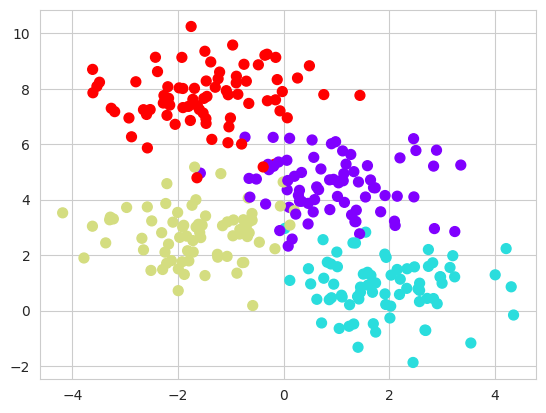

In [3]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

Un árbol de decisión simple construido sobre estos datos dividirá iterativamente los datos a lo largo de uno u otro eje según algún criterio cuantitativo, y en cada nivel asignará la etiqueta de la nueva región de acuerdo con un voto mayoritario de los puntos que contiene.
La figura siguiente presenta una visualización de los primeros cuatro niveles de un clasificador de árbol de decisión para estos datos.


![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/images/05.08-decision-tree-levels.png?raw=1)
[figure source in Appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Decision-Tree-Levels)

Observa que después de la primera división, todos los puntos en la rama superior permanecen sin cambios, por lo que no es necesario subdividir más esta rama.
Excepto en los nodos que contienen únicamente un color, en cada nivel *toda* región se vuelve a dividir a lo largo de una de las dos características.


Este proceso de ajustar un árbol de decisión a nuestros datos se puede realizar en Scikit-Learn con el estimador ``DecisionTreeClassifier``:

In [4]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

Vamos a escribir una función auxiliar para ayudarnos a visualizar la salida del clasificador:


In [5]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()

    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

Ahora podemos examinar cómo se ve la clasificación del árbol de decisión (ver la figura siguiente):


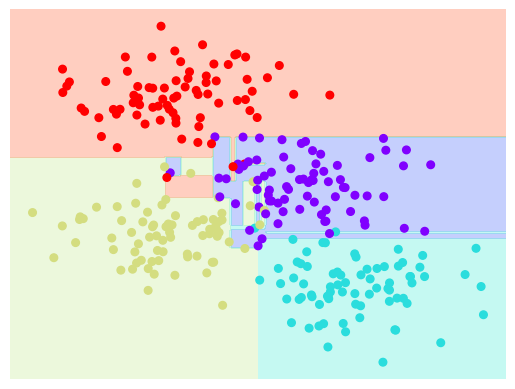

In [6]:
visualize_classifier(DecisionTreeClassifier(), X, y)

In [7]:

import helpers
helpers.plot_tree_interactive(X, y);

ModuleNotFoundError: No module named 'helpers'

Observa que a medida que aumenta la profundidad, tendemos a obtener regiones de clasificación con formas muy extrañas; por ejemplo, a una profundidad de cinco, hay una región púrpura alta y delgada entre las regiones amarilla y azul.
Está claro que esto se debe menos a la verdadera distribución intrínseca de los datos y más a las propiedades particulares del muestreo o al ruido presente en los datos.
Es decir, este árbol de decisión, incluso con solo cinco niveles de profundidad, está claramente sobreajustando nuestros datos.


### Árboles de Decisión y Sobreajuste

Este sobreajuste resulta ser una propiedad general de los árboles de decisión: es muy fácil profundizar demasiado en el árbol y, por lo tanto, ajustar detalles de los datos particulares en lugar de las propiedades generales de las distribuciones de las que provienen.
Otra forma de observar este sobreajuste es mirar modelos entrenados con diferentes subconjuntos de los datos; por ejemplo, en esta figura entrenamos dos árboles diferentes, cada uno con la mitad de los datos originales.


![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/images/05.08-decision-tree-overfitting.png?raw=1)
[figure source in Appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Decision-Tree-Overfitting)

Está claro que en algunos lugares los dos árboles producen resultados consistentes (por ejemplo, en las cuatro esquinas), mientras que en otros lugares los dos árboles ofrecen clasificaciones muy diferentes (por ejemplo, en las regiones entre dos grupos de puntos).
La observación clave es que las inconsistencias tienden a ocurrir donde la clasificación es menos segura, y por lo tanto, al usar información de *ambos* árboles, ¡podríamos obtener un mejor resultado!


Si estás ejecutando este cuaderno en vivo, la siguiente función te permitirá mostrar de manera interactiva los ajustes de los árboles entrenados con un subconjunto aleatorio de los datos:


In [ ]:
# helpers_05_08 is found in the online appendix
import helpers
helpers.randomized_tree_interactive(X, y)

Así como usar información de dos árboles mejora nuestros resultados, podríamos esperar que usar información de muchos árboles los mejore aún más.


## Conjuntos de Estimadores: Bosques Aleatorios

Esta idea—que múltiples estimadores con sobreajuste pueden combinarse para reducir el efecto de este sobreajuste—es la base de un método de conjunto llamado *bagging*.
Bagging utiliza un conjunto (quizás una “bolsa variada”) de estimadores paralelos, cada uno de los cuales sobreajusta los datos, y promedia los resultados para obtener una mejor clasificación.
Un conjunto de árboles de decisión aleatorizados se conoce como *bosque aleatorio* (*random forest*).

Este tipo de clasificación por bagging se puede realizar manualmente usando el meta-estimador `BaggingClassifier` de Scikit-Learn, como se muestra aquí (ver la figura siguiente):


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

En este ejemplo, hemos aleatorizado los datos ajustando cada estimador con un subconjunto aleatorio del 80 % de los puntos de entrenamiento.
En la práctica, los árboles de decisión se aleatorizan de manera más efectiva introduciendo cierta aleatoriedad en cómo se eligen las divisiones: de esta manera, todos los datos contribuyen al ajuste cada vez, pero los resultados del ajuste mantienen la aleatoriedad deseada.
Por ejemplo, al determinar en qué característica dividir, el árbol aleatorizado podría seleccionar entre varias de las mejores características.
Puedes leer más detalles técnicos sobre estas estrategias de aleatorización en la [documentación de Scikit-Learn](http://scikit-learn.org/stable/modules/ensemble.html#forest) y en las referencias allí incluidas.

En Scikit-Learn, un conjunto optimizado de árboles de decisión aleatorizados se implementa en el estimador `RandomForestClassifier`, que se encarga automáticamente de toda la aleatorización.
Todo lo que necesitas hacer es seleccionar un número de estimadores, y rápidamente—en paralelo, si se desea—ajustará el conjunto de árboles (ver la figura siguiente):


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

Vemos que al promediar sobre 100 modelos perturbados aleatoriamente, obtenemos un modelo global que se aproxima mucho más a nuestra intuición sobre cómo debería dividirse el espacio de parámetros.


## Regresión con Bosques Aleatorio

En la sección anterior consideramos los bosques aleatorios en el contexto de la clasificación.
Los bosques aleatorios también pueden aplicarse en el caso de regresión (es decir, con variables continuas en lugar de categóricas). El estimador a utilizar para esto es `RandomForestRegressor`, y la sintaxis es muy similar a la que vimos anteriormente.

Considera los siguientes datos, obtenidos de la combinación de una oscilación rápida y otra lenta (ver la figura siguiente):


In [ ]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

Usando el regresor de bosques aleatorios, podemos encontrar la curva de mejor ajuste de la siguiente manera (ver la figura siguiente):


In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

Aquí, el modelo verdadero se muestra con la curva gris suave, mientras que el modelo de bosque aleatorio se muestra con la curva roja irregular.
El modelo no paramétrico de bosque aleatorio es lo suficientemente flexible como para ajustarse a los datos multiperiodo, ¡sin que necesitemos especificar un modelo multiperiodo!


## Ejemplo: Bosque Aleatorio para Clasificar Dígitos

En el Capítulo 38 trabajamos un ejemplo usando el conjunto de datos *digits* incluido en Scikit-Learn.
Vamos a usarlo de nuevo aquí para ver cómo se puede aplicar el clasificador de bosque aleatorio en este contexto:


In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

Para recordarnos qué estamos observando, vamos a visualizar los primeros puntos de datos (ver la figura siguiente):


In [ ]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')

    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

Podemos clasificar los dígitos usando un bosque aleatorio de la siguiente manera:


In [ ]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

Veamos el informe de clasificación de este clasificador:


In [ ]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

Y, para mayor claridad, grafiquemos la matriz de confusión (ver la figura siguiente):


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
            cbar=False, cmap='Blues')
plt.xlabel('true label')
plt.ylabel('predicted label');

Encontramos que un bosque aleatorio simple, sin ajuste, resulta en una clasificación bastante precisa del conjunto de datos de dígitos.


## Resumen

Este capítulo proporcionó una breve introducción al concepto de estimadores de conjunto, y en particular al bosque aleatorio, un conjunto de árboles de decisión aleatorizados.
Los bosques aleatorios son un método poderoso con varias ventajas:

* Tanto el entrenamiento como la predicción son muy rápidos, debido a la simplicidad de los árboles de decisión subyacentes. Además, ambas tareas se pueden paralelizar de manera sencilla, ya que los árboles individuales son entidades completamente independientes.
* Los múltiples árboles permiten una clasificación probabilística: un voto mayoritario entre los estimadores proporciona una estimación de la probabilidad (accesible en Scikit-Learn con el método `predict_proba`).
* El modelo no paramétrico es extremadamente flexible y, por lo tanto, puede desempeñarse bien en tareas que otros estimadores tienden a subajustar.

Una desventaja principal de los bosques aleatorios es que los resultados no son fácilmente interpretables: es decir, si deseas sacar conclusiones sobre el *significado* del modelo de clasificación, los bosques aleatorios pueden no ser la mejor opción.
